### Imports

In [ ]:
# ML imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier

# Data analysis and stats imports
import numpy as np
import pandas as pd
from scipy.stats import expon, reciprocal
from scipy.spatial.distance import pdist, squareform

# Data visualization imports
import seaborn as sns
import matplotlib.pyplot as plt 

### Get data

In [3]:
train_df = pd.read_csv('C:\\Users\\Samir\\Documents\\GitHub\\Projet-STT-3795\\src\\data\\wav_files_clean\\train_preprocessed_data')
test_df = pd.read_csv('C:\\Users\\Samir\\Documents\\GitHub\\Projet-STT-3795\\src\\data\\wav_files_clean\\test_preprocessed_data')
validation_df = pd.read_csv('C:\\Users\\Samir\\Documents\\GitHub\\Projet-STT-3795\\src\\data\\wav_files_clean\\validation_preprocessed_data')

df = pd.concat([train_df, test_df, validation_df]).reset_index().iloc[:, 2:]
df.rename(columns={'0': 'label'}, inplace=True)

df_without_label = df.iloc[:, 0:-1]

Check multicolinearity

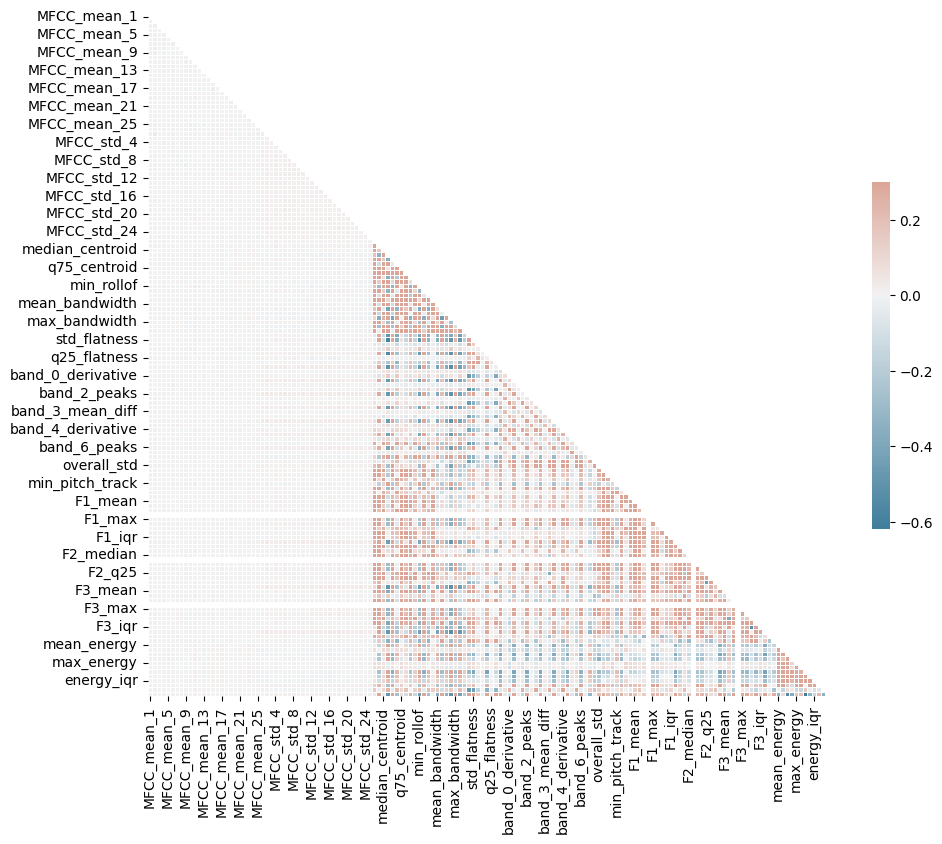

In [4]:
corr = df_without_label.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

### Principal components

In [5]:
def get_PCs(dataframe, percentage_variance):
    print()
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(dataframe)
    print(f'Scaled_df Mean = {np.mean(scaled_df)},\nScaled_df Std = {np.std(scaled_df)}')


    pca_T = PCA()
    pca_T.fit_transform(scaled_df)
    ev = pca_T.explained_variance_
    print()
    print(f'Total variance = {sum(ev)}')

    pca = PCA(percentage_variance/100)
    principal_components = pca.fit_transform(scaled_df)
    explained_variance = pca.explained_variance_
    percentage = sum(pca.explained_variance_ratio_)
    print(f'Real percentage = {percentage}')
    print(f'Variance for {round(percentage*100, 2)}% = {sum(explained_variance)}')
    print(f'Number of PCs for {round(percentage*100, 2)}% = {len(explained_variance)}')
    print(f'Attribute lost = {len(scaled_df[0]) - len(explained_variance)}')
    names = pca.get_feature_names_out()
    return pd.DataFrame(data=principal_components, columns=names)


MDS

In [6]:
# MDS classique
def mds(dataframe, n_components): 
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(dataframe)
    print(f'Scaled_df Mean = {np.mean(scaled_df)},\nScaled_df Std = {np.std(scaled_df)}')
    mds = MDS(n_components=n_components, random_state=42, dissimilarity='euclidean')
    mds_transformed = mds.fit_transform(scaled_df)
    return pd.DataFrame(mds_transformed, columns=[f'Component_{i+1}' for i in range(n_components)])

# Mahalanobis distance matrix set up 
def compute_mahalanobis_distance_matrix(X):
    # Matrice singuliere a normaliser
    VI = np.linalg.inv(np.cov(X.T) + np.eye(X.shape[1]) * 1e-4)
    mahalanobis_dist = pdist(X, metric='mahalanobis', VI=VI)
    distance_matrix = squareform(mahalanobis_dist)
    return distance_matrix

# MDS with mahalanobis distance
def mds_mahalanobis(dataframe, n_components):
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(dataframe)
    mahalanobis_distance_matrix = compute_mahalanobis_distance_matrix(scaled_df)
    mds = MDS(n_components=n_components, random_state=42, dissimilarity='precomputed')
    mds_transformed = mds.fit_transform(mahalanobis_distance_matrix)
    return pd.DataFrame(mds_transformed, columns=[f'Component_{i+1}' for i in range(n_components)])



In [7]:
# PCA
#df_pca = get_PCs(df_without_label, 99)
#df_pca['label'] = df['label']

# MDS with mahalanobis
df_mds = mds_mahalanobis(df_without_label, 70)
df_mds['label'] = df['label']

## Models

### Training

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df_mds.iloc[:, 0:-1], df_mds['label'], stratify=df_mds['label'], test_size=0.3, random_state=42) 

# Model initialization
svm = SVC(verbose=3)
random_forest = RandomForestClassifier(verbose=3)
nn = MLPClassifier(verbose=3)

# Models fiting
print("Training SVM")
svm.fit(X_train, Y_train)
print("Training RFC")
random_forest.fit(X_train, Y_train)


AttributeError: 'function' object has no attribute 'iloc'

### Predictions

In [ ]:
# Models prediction
svm_predictions = svm.predict(X_test)
random_forest_predictions = random_forest.predict(X_test)

### Metrics

#### Accuracy

In [ ]:
svm_accuracy = accuracy_score(Y_test, svm_predictions)
random_forest_accuracy = accuracy_score(Y_test, random_forest_predictions)

print(f'SVM accuracy: {svm_accuracy}')
print(f'RDF accuracy: {random_forest_accuracy}')

SVM accuracy: 0.08500788022064618
RDF accuracy: 0.08500788022064618


RandomizedSearch XGBoost

In [ ]:
"""
param_grid_xgb = {
    'max_depth': [3, 4, 5], 
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'lambda': [0, 1, 10],  
    'alpha': [0, 0.1, 1]  
}
svm_conf_matrix = confusion_matrix(Y_test, svm_predictions)
rdf_conf_matrix = confusion_matrix(Y_test, random_forest_predictions)

xgbc = XGBClassifier(random_state=42)

# Accuracy = (TP + TN)/(TP + TN + FP + FN) -> num pred correct / total number of pred
grid_search = RandomizedSearchCV(estimator=xgbc, param_grid=param_grid_xgb, n_iter = 100, scoring='f1', cv=5, verbose=1, random_state = 42)
grid_search.fit(X_train, Y_train)
# Print the best parameters and the best F1 score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_}")
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)
test_f1_score = f1_score(Y_test, y_pred)

print(f"Test F1 Score: {test_f1_score}")
"""

'\nparam_grid_xgb = {\n    \'max_depth\': [3, 4, 5], \n    \'n_estimators\': [100, 200],\n    \'learning_rate\': [0.01, 0.1, 0.2],\n    \'lambda\': [0, 1, 10],  \n    \'alpha\': [0, 0.1, 1]  \n}\nsvm_conf_matrix = confusion_matrix(Y_test, svm_predictions)\nrdf_conf_matrix = confusion_matrix(Y_test, random_forest_predictions)\n\nxgbc = XGBClassifier(random_state=42)\n\n# Accuracy = (TP + TN)/(TP + TN + FP + FN) -> num pred correct / total number of pred\ngrid_search = RandomizedSearchCV(estimator=xgbc, param_grid=param_grid_xgb, n_iter = 100, scoring=\'f1\', cv=5, verbose=1, random_state = 42)\ngrid_search.fit(X_train, Y_train)\n# Print the best parameters and the best F1 score\nprint(f"Best parameters found: {grid_search.best_params_}")\nprint(f"Best F1 score: {grid_search.best_score_}")\nbest_estimator = grid_search.best_estimator_\ny_pred = best_estimator.predict(X_test)\ntest_f1_score = f1_score(Y_test, y_pred)\n\nprint(f"Test F1 Score: {test_f1_score}")\n'

RandomizedSearch SVM

In [ ]:
param_grid = {
    'C': reciprocal(0.001, 1000),
    'gamma': expon(scale=1.0),
    'kernel': ['linear', 'rbf', 'poly']
}

svm_clf = SVC(random_state=42)
random_search_svm = RandomizedSearchCV(svm_clf, param_grid, n_iter=100, verbose=2, cv=5, random_state=42, n_jobs=-1, scoring = 'f1')
random_search_svm.fit(X_train, Y_train)
print("Best parameters for SVM:", random_search_svm.best_params_)
print("Best score:", random_search_svm.best_score_)

RandomizedSearch Random Forest Classifier

In [ ]:
param_grid_rf = {
    'n_estimators': [80, 100, 200],
    'max_depth': [3, 4, 5, None],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None] 
}

rfc = RandomForestClassifier(random_state=42)

random_search_rf = RandomizedSearchCV(rfc, param_grid_rf, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring = 'f1')
random_search_rf.fit(X_train, Y_train)
print("Best parameters:", random_search_rf.best_params_)
print("Best score:", random_search_rf.best_score_)

XGBClassifier evaluation

In [ ]:
"""
param_grid_svm = {
    'C': reciprocal(0.001, 1000),
    'gamma': expon(scale=1.0),
    'kernel': ['linear', 'rbf', 'poly']
}

svm_clf = SVC(random_state=42)
random_search_svm = RandomizedSearchCV(svm_clf, param_grid_svm, n_iter=100, verbose=2, cv=5, random_state=42, n_jobs=-1, scoring = 'f1')
random_search_svm.fit(X_train, Y_train)
print("Best parameters for SVM:", random_search_svm.best_params_)
print("Best score:", random_search_svm.best_score_)
"""

'\nparam_grid_svm = {\n    \'C\': reciprocal(0.001, 1000),\n    \'gamma\': expon(scale=1.0),\n    \'kernel\': [\'linear\', \'rbf\', \'poly\']\n}\n\nsvm_clf = SVC(random_state=42)\nrandom_search_svm = RandomizedSearchCV(svm_clf, param_grid_svm, n_iter=100, verbose=2, cv=5, random_state=42, n_jobs=-1, scoring = \'f1\')\nrandom_search_svm.fit(X_train, Y_train)\nprint("Best parameters for SVM:", random_search_svm.best_params_)\nprint("Best score:", random_search_svm.best_score_)\n'

RandomizedSearch Random Forest Classifier

In [ ]:
"""
param_grid_rf = {
    'n_estimators': [80, 100, 200],
    'max_depth': [3, 4, 5, None],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None] 
}

rfc = RandomForestClassifier(random_state=42)

random_search_rf = RandomizedSearchCV(rfc, param_grid_rf, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring = 'f1')
random_search_rf.fit(X_train, Y_train)
print("Best parameters:", random_search_rf.best_params_)
print("Best score:", random_search_rf.best_score_)
"""

'\nparam_grid_rf = {\n    \'n_estimators\': [80, 100, 200],\n    \'max_depth\': [3, 4, 5, None],  \n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'auto\', \'sqrt\', \'log2\', None] \n}\n\nrfc = RandomForestClassifier(random_state=42)\n\nrandom_search_rf = RandomizedSearchCV(rfc, param_grid_rf, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring = \'f1\')\nrandom_search_rf.fit(X_train, Y_train)\nprint("Best parameters:", random_search_rf.best_params_)\nprint("Best score:", random_search_rf.best_score_)\n'

XGBClassifier evaluation

In [ ]:
target = df['label']
report = classification_report(Y_test, svm_predictions)
print(report)

c:\Users\Kamen\.pyenv\pyenv-win\versions\3.9.12\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Kamen\.pyenv\pyenv-win\versions\3.9.12\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                   precision    recall  f1-score   support

           Arabic       0.00      0.00      0.00       274
           Basque       0.00      0.00      0.00       190
           Breton       0.14      0.58      0.22       353
          Catalan       0.00      0.00      0.00       182
    Chinese_China       0.00      0.00      0.00       179
 Chinese_Hongkong       0.00      0.00      0.00       201
   Chinese_Taiwan       0.06      0.19      0.09       299
          Chuvash       0.05      0.08      0.06       217
            Czech       0.00      0.00      0.00       243
          Dhivehi       0.00      0.00      0.00       196
            Dutch       0.00      0.00      0.00       254
          English       0.00      0.00      0.00       173
        Esperanto       0.00      0.00      0.00       193
         Estonian       0.14      0.21      0.17       162
           French       0.00      0.00      0.00       183
          Frisian       0.00      0.00      0.00       

c:\Users\Kamen\.pyenv\pyenv-win\versions\3.9.12\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
